In [72]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import torchvision

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from tqdm import tqdm


def seed_everything(SEED = 42): #seed값 맞춰놓고. 42로
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

SEED = 42
seed_everything(SEED = SEED)

In [108]:
batch_size = 32
learning_rate = 0.00002
num_epoch = 10

In [109]:
data = datasets.Caltech101("./", download=True)

Files already downloaded and verified


In [110]:
image_paths = list(paths.list_images('./caltech101/101_ObjectCategories')) #그림들 불러 모아서 paths도 위에 import 해준 패키지

data = []
labels = []

for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2] #label이 faces. sep가 '/'여서 그 두번째 앞에꺼. 그래서 faces
    if label == "BACKGROUND_Google":
        continue

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

100%|██████████| 9144/9144 [00:09<00:00, 1011.27it/s]
<ipython-input-110-7b4d2eff57a1>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [111]:
label_names = labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
print(labels) #원핫 인코딩 되어있는 것.
print(label_names)

101
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['crayfish' 'crayfish' 'crayfish' ... 'chandelier' 'chandelier'
 'chandelier']


In [112]:
count_arr = []
label_arr = []

for i in range(len(lb.classes_)):
    count = 0
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

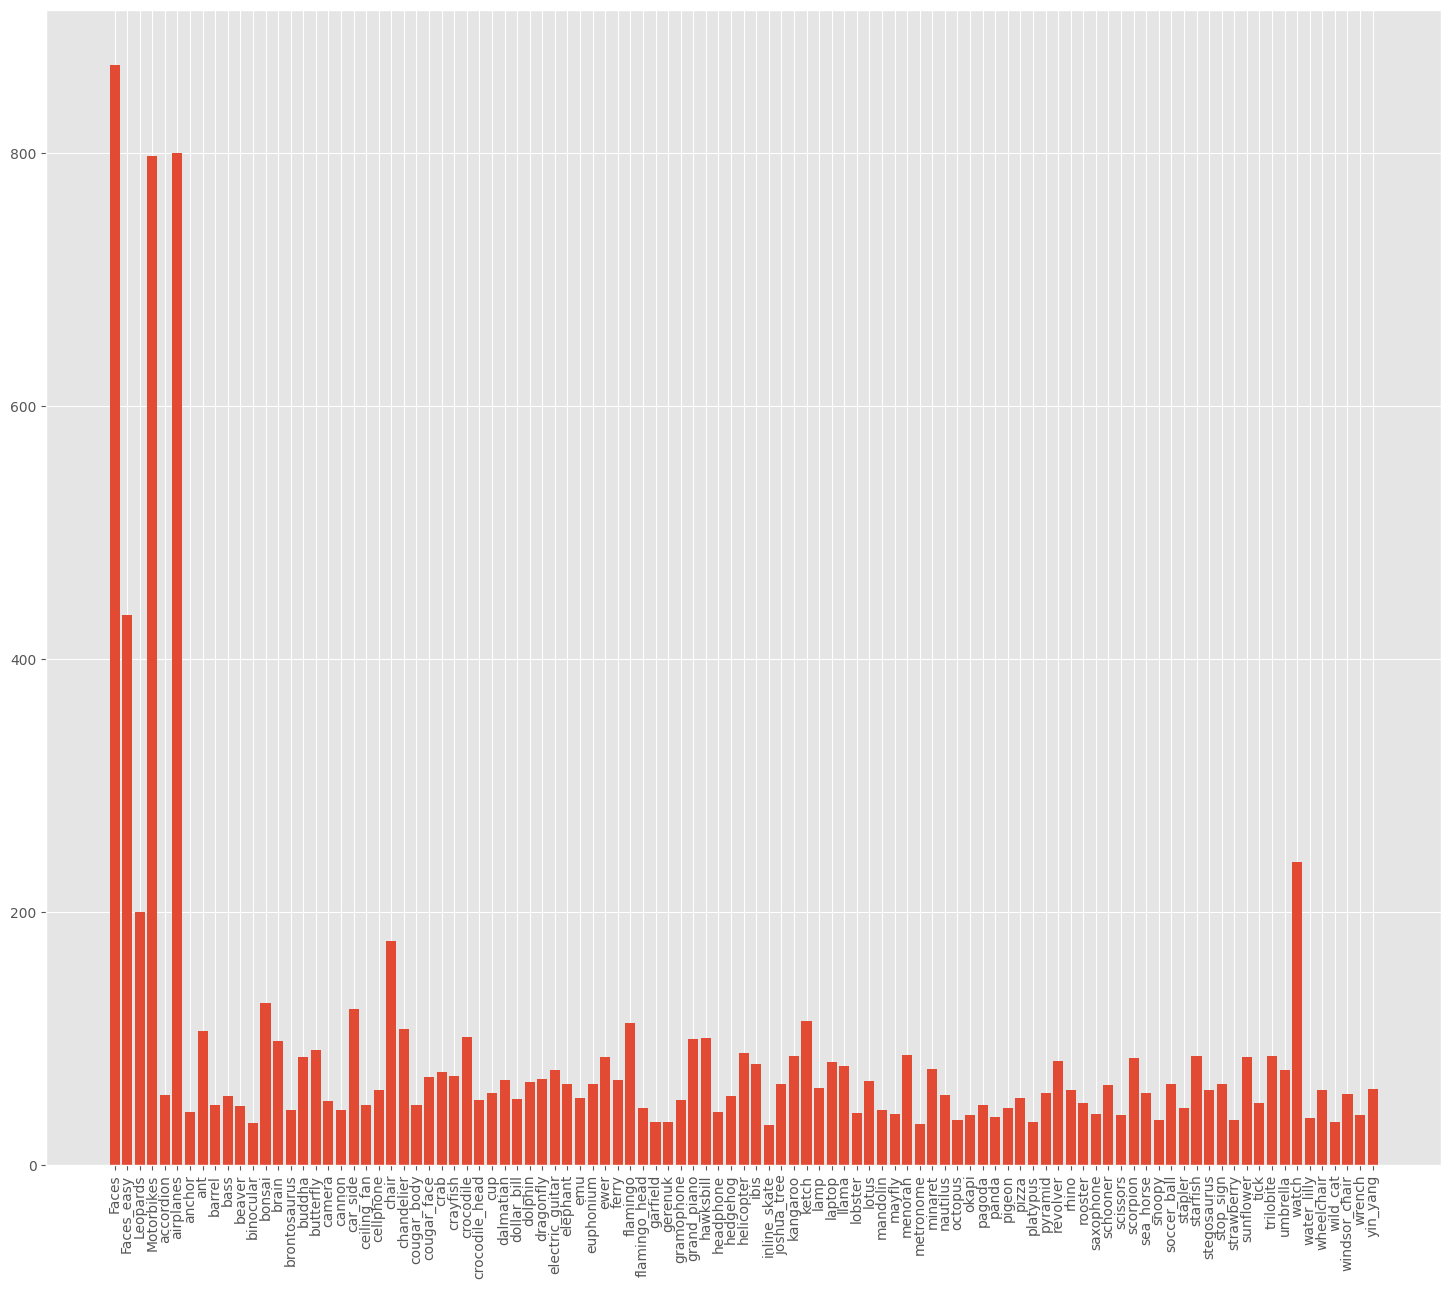

In [113]:
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,)
plt.xticks(rotation='vertical')
plt.show()

In [114]:
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


In [115]:
class CustomDataset(Dataset): #dataLoader에 numpy배열이라서 막 넣어주면 안되고, 이런식 만들어줘서 넣어야함.
    def __init__(self, images, labels, transforms=None):
        self.x = images #X에 imges들어가고,
        self.y = labels #y에 labels 들어가고,
        self.transforms = transforms
         
    def __len__(self): #길이 받아오는 것.
        return (len(self.x))
    
    def __getitem__(self, i): #item받아오는 것.
        data = self.x[i][:]
        
        if self.transforms is not None:
            data = self.transforms(data)
            
        return (data, self.y[i])

In [116]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [117]:
print(train_transform)

Compose(
    ToPILImage()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [118]:
train_data = CustomDataset(x_train, y_train, train_transform) #위에 CustomDataset. 함수 만들어준 것.
val_data = CustomDataset(x_val, y_val, val_transform)
test_data = CustomDataset(x_test, y_test, val_transform)
 
# dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

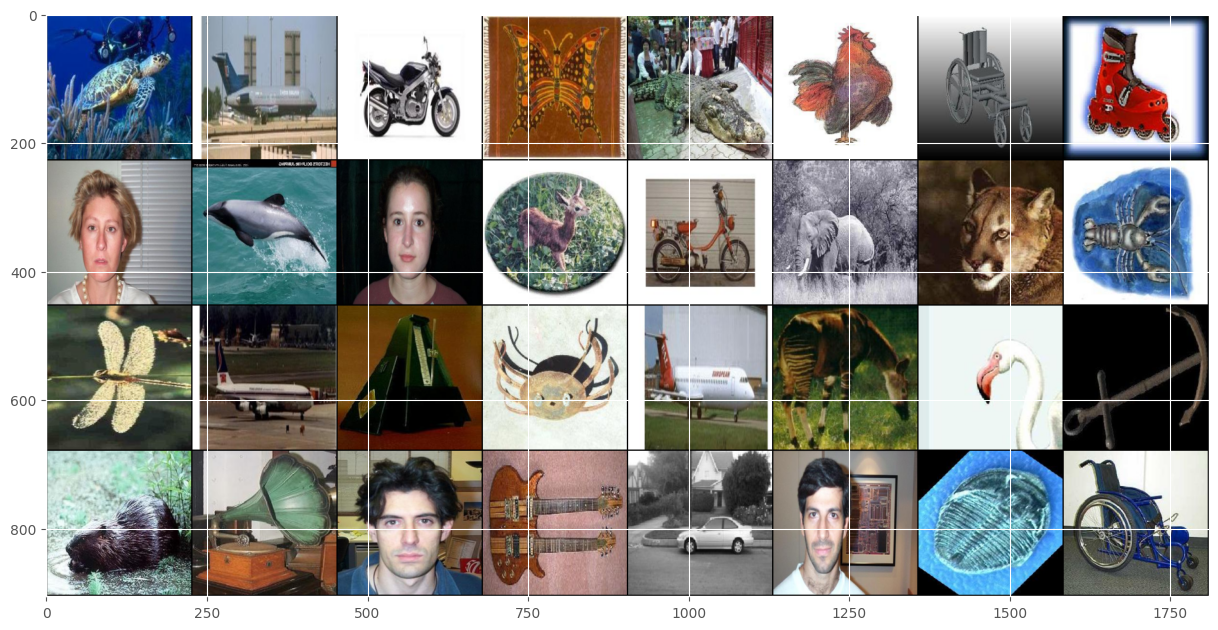

In [119]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

In [120]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2), 
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding=1), 
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2,2),            
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3,padding=1), 
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels = 64, out_channels = 3,  kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 2 * 2 풀링 레이어.
        )

        self.fc_layer = nn.Sequential(  
            nn.Linear(224*224*3, len(lb.classes_)))        
        
    def forward(self,x):
        x = x.view(batch_size,-1)
        out = self.fc_layer(x)
        return out

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [122]:
def train(model, dataloader):
    model.train() #train 모드로 해주고,
    train_running_loss = 0.0 # 여기다가 다 쌓아가는 느낌으로다가.
    train_running_correct = 0 #
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)  # 0번 인덱스가 data, 1번 인덱스가 target
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_func(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [123]:
def validate(model, dataloader):
    model.eval() #validation 모드로 바꿔주고

    val_running_loss = 0.0
    val_running_correct = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)): #tqdm쓰면 epoch 돌 때 진행률 보임.
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = loss_func(outputs, torch.max(target, 1)[1])
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [124]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} of {num_epoch}")
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader) # train
    val_epoch_loss, val_epoch_accuracy = validate(model, val_loader) # validate
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start) / 60, 'minutes')

Epoch 1 of 10


100%|██████████| 162/162 [00:11<00:00, 13.78it/s]


Train Loss: 0.1252, Train Acc: 26.21


100%|██████████| 54/54 [00:03<00:00, 15.47it/s]


Val Loss: 0.1085, Val Acc: 35.25
Epoch 2 of 10


100%|██████████| 162/162 [00:11<00:00, 14.02it/s]


Train Loss: 0.0986, Train Acc: 36.29


100%|██████████| 54/54 [00:03<00:00, 15.55it/s]


Val Loss: 0.0997, Val Acc: 36.98
Epoch 3 of 10


100%|██████████| 162/162 [00:11<00:00, 14.62it/s]


Train Loss: 0.0886, Train Acc: 40.56


100%|██████████| 54/54 [00:03<00:00, 14.51it/s]


Val Loss: 0.0992, Val Acc: 39.63
Epoch 4 of 10


100%|██████████| 162/162 [00:10<00:00, 15.05it/s]


Train Loss: 0.0805, Train Acc: 44.84


100%|██████████| 54/54 [00:04<00:00, 13.12it/s]


Val Loss: 0.0966, Val Acc: 40.26
Epoch 5 of 10


100%|██████████| 162/162 [00:10<00:00, 14.90it/s]


Train Loss: 0.0744, Train Acc: 47.97


100%|██████████| 54/54 [00:03<00:00, 16.00it/s]


Val Loss: 0.0964, Val Acc: 39.80
Epoch 6 of 10


100%|██████████| 162/162 [00:11<00:00, 13.79it/s]


Train Loss: 0.0696, Train Acc: 51.03


100%|██████████| 54/54 [00:03<00:00, 15.64it/s]


Val Loss: 0.0938, Val Acc: 41.59
Epoch 7 of 10


100%|██████████| 162/162 [00:11<00:00, 14.34it/s]


Train Loss: 0.0642, Train Acc: 54.93


100%|██████████| 54/54 [00:03<00:00, 15.75it/s]


Val Loss: 0.0965, Val Acc: 40.73
Epoch 8 of 10


100%|██████████| 162/162 [00:11<00:00, 14.45it/s]


Train Loss: 0.0607, Train Acc: 57.31


100%|██████████| 54/54 [00:03<00:00, 14.20it/s]


Val Loss: 0.0935, Val Acc: 42.63
Epoch 9 of 10


100%|██████████| 162/162 [00:10<00:00, 14.93it/s]


Train Loss: 0.0555, Train Acc: 60.29


100%|██████████| 54/54 [00:04<00:00, 12.90it/s]


Val Loss: 0.0942, Val Acc: 40.78
Epoch 10 of 10


100%|██████████| 162/162 [00:11<00:00, 14.59it/s]


Train Loss: 0.0539, Train Acc: 62.04


100%|██████████| 54/54 [00:03<00:00, 15.80it/s]

Val Loss: 0.0930, Val Acc: 42.05
2.4815296729405723 minutes


In [125]:
torch.save(model.state_dict(), f"model_{num_epoch}.pth") # .pth로 파일 저장.

[26.205571565802114, 36.292026897214214, 40.557156580211334, 44.84149855907781, 47.9731027857829, 51.027857829010564, 54.92795389048992, 57.3102785782901, 60.288184438040346, 62.03650336215178]
[0.12520191383178594, 0.09855895560023649, 0.08862766882871688, 0.08054141657038678, 0.0743723567693309, 0.06961857997718393, 0.06421983155004114, 0.060689803239362496, 0.05554647129619499, 0.05394256851286068]
[35.25345622119816, 36.9815668202765, 39.63133640552996, 40.264976958525345, 39.80414746543779, 41.58986175115207, 40.725806451612904, 42.62672811059908, 40.78341013824885, 42.05069124423963]
[0.10849261489881348, 0.09970135821999493, 0.09923249579245044, 0.09664569190844963, 0.096448724995011, 0.09375039731851921, 0.09647145771211194, 0.09350224546573128, 0.09418328168205402, 0.09299597769014296]


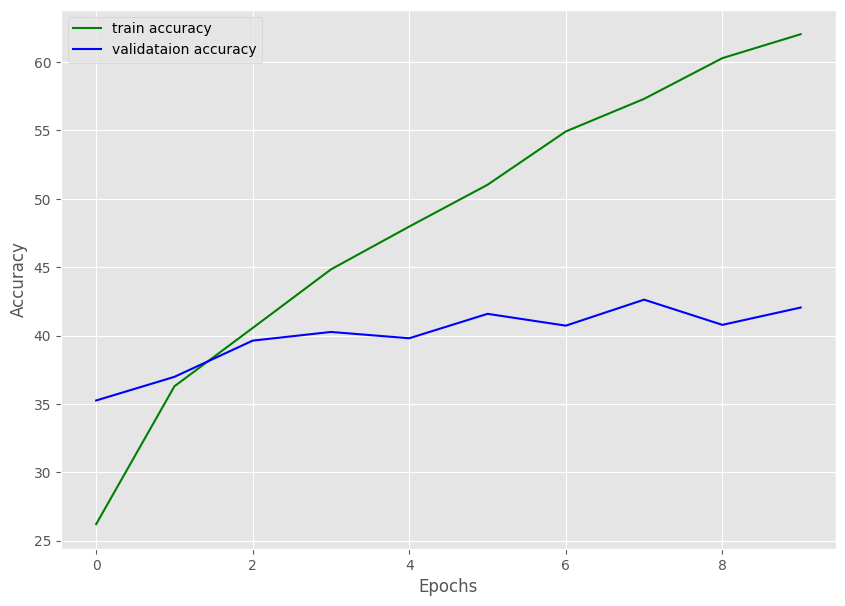

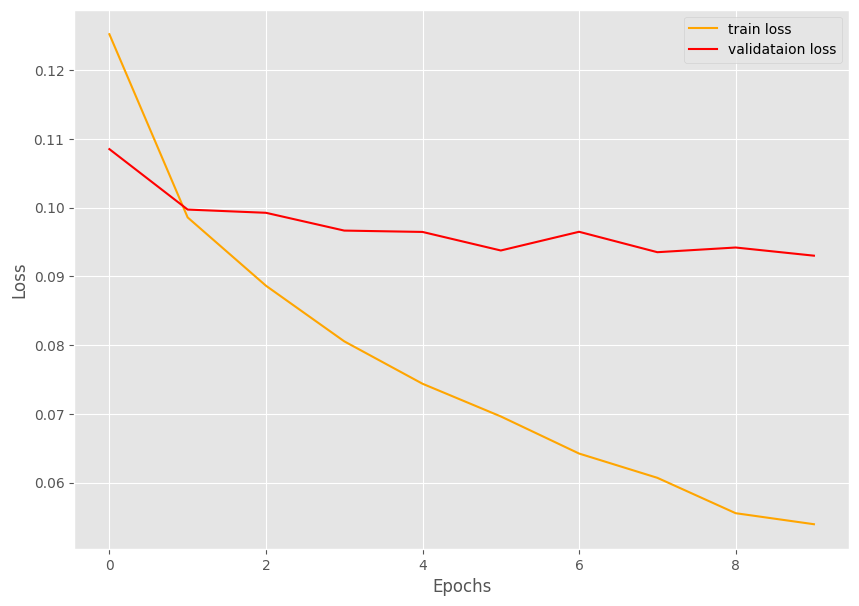

['val_loss.pkl']

In [126]:
print(train_accuracy)
print(train_loss)
print(val_accuracy)
print(val_loss)

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

import joblib
joblib.dump(train_accuracy, 'train_accuracy.pkl') #이 받아온 데이터를 저장 가능. joblib.dump로.
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')


#여기까지 오버피팅 빠졌는지, 정확도 최대로 올렸는지 확인하는 것이고, 

In [127]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs = data[0].to(device, non_blocking=True)
        target = data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

Accuracy of the network on test images: 42.014 %


In [128]:
# 1st: 35,  2nd: 44 , 3nd: 40
# 아... 진짜 뭐이리 안되지....
#현재는 accuracy 42%